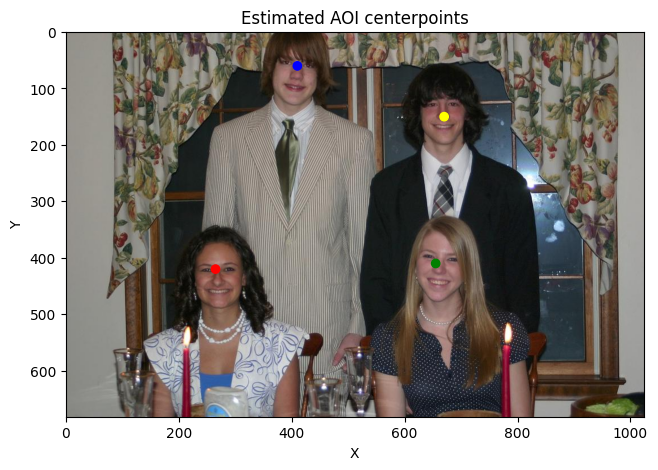

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import networkx as nx

# 14, 17, 29, 38, 56!!!
dataset_index = 56
img_path = f"../TrainingDataset/TrainingData/Images/{dataset_index}.png"
td_data_path = f"../TrainingDataset/TrainingData/TD/TD_scanpath_{dataset_index}.txt"
asd_data_path = f"../TrainingDataset/TrainingData/ASD/ASD_scanpath_{dataset_index}.txt"
td_data = pd.read_csv(td_data_path, usecols=[1, 2, 3])
asd_data = pd.read_csv(asd_data_path, usecols=[1, 2, 3])
image = Image.open(img_path)


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
AOIS = pd.DataFrame(
    {
        "x": np.array([410, 265, 655, 670], dtype=float),
        "y": np.array([60, 420, 410, 150], dtype=float),
        "color": ["blue", "red", "green", "yellow"],
    }
)
ax.scatter(AOIS["x"], AOIS["y"], color=AOIS["color"])
ax.set(title="Estimated AOI centerpoints", xlabel="X", ylabel="Y")
ax.imshow(image)

In [2]:
def get_closest_aoi(aois: pd.DataFrame, data: pd.DataFrame) -> None:
    distance_cols = []
    for aoi in range(len(aois)):
        distance_cols.append(f"distance_{aoi}")

        data[f"distance_{aoi}"] = np.linalg.norm(
            data[["x", "y"]].values - np.array([aois.loc[aoi, "x"], aois.loc[aoi, "y"]]), axis=1
        )

    data["AOI"] = data[distance_cols].idxmin(axis=1).str.replace("distance_", "").astype(int)
    
get_closest_aoi(AOIS, td_data)
get_closest_aoi(AOIS, asd_data)

[Text(0.5, 1.0, 'ASD')]

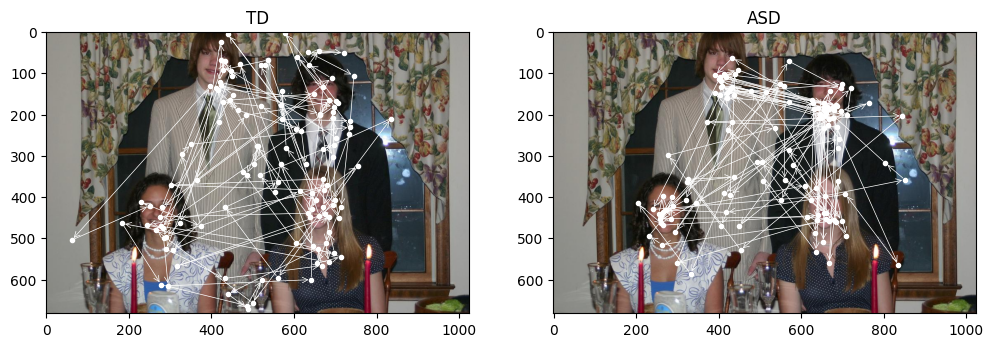

In [3]:
def trace_plot(ax, df: pd.DataFrame, aois):
    for i in range(len(df.index) - 1):
        ax.annotate(
            "",
            xy=(df["x"][i + 1], df["y"][i + 1]),
            xytext=(df["x"][i], df["y"][i]),
            arrowprops=dict(arrowstyle="->", color="white", lw=0.5),
        )
    for aoi in range(len(aois)):
        x = df[df["AOI"] == aoi]["x"]
        y = df[df["AOI"] == aoi]["y"]
        ax.scatter(x, y, color="white", marker=".")


fig, ax = plt.subplots(1, 2, figsize=(12, 8))
trace_plot(ax[0], asd_data, AOIS),
ax[0].imshow(image)
ax[0].set(title="TD")

trace_plot(ax[1], td_data, AOIS),
ax[1].imshow(image)
ax[1].set(title="ASD")

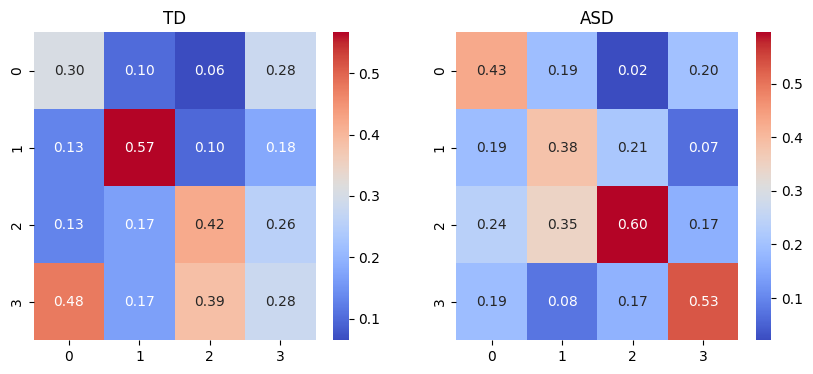

In [4]:
def transition_matrix(aois: pd.DataFrame, data: pd.DataFrame) -> np.ndarray:
    # from \ to -> row \ col
    transition_matrix = np.zeros(shape=(len(aois.index), len(aois.index)), dtype=int)
    for i in range(len(data.index)-1):
        from_aoi = data.loc[i, "AOI"]
        to_aoi = data.loc[i+1, "AOI"]
        transition_matrix[from_aoi][to_aoi] += 1
    rows_sum = np.sum(transition_matrix, axis=1)
    return transition_matrix / rows_sum

td_matrix = transition_matrix(AOIS, td_data)
asd_matrix = transition_matrix(AOIS, asd_data)

def heatmap_pair(G1: np.ndarray, G2: np.ndarray, main_title="", title1="G1", title2="G2"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].set(title=title1)
    ax[1].set(title=title2)
    fig.suptitle(main_title)
    sns.heatmap(G1, fmt='.2f', cmap='coolwarm', annot=True, ax=ax[0])
    sns.heatmap(G2, fmt='.2f', cmap='coolwarm', annot=True, ax=ax[1])

heatmap_pair(td_matrix, asd_matrix, "", "TD", "ASD")

# Random walk kernels


Random walk kernel: computes similarity between two graphs by counting matching random walks in them

$$
K(G, G') = \sum_{l=0}^{\infty} \lambda^{l} \cdot \mathbf{1}^{\top} (A^{l} \otimes A'^{l}) \mathbf{1}
$$


As a matrix inverse:

$$
K(G, G') = \mathbf{1}^{\top} \left( I - \lambda (A \otimes A') \right)^{-1} \mathbf{1}
$$


where 
- l is the lenght of the walks
- ⊗ is the Kronecker product. $A^{l} \otimes A'^{l}$ has size (mn, mn) for graph of size (m,m) and (n,n), represents all possible simultaneous walks in both graphs. 
- $\lambda$ is a decay factor to give less as walks get longer, has to be less than the spectral radius (largest eigenvalue) of the product matrix, so that the sum converges.

In [5]:
def weighted_random_walk_kernel(G1: np.ndarray, G2: np.ndarray, decay: float = 0.9, normalize: bool = False, ) -> float:
    rho_1 = max(abs((np.linalg.eigvals(G1))))
    rho_2 = max(abs((np.linalg.eigvals(G2))))
    decay_max = 1 / (rho_1 * rho_2)
    decay_safe = decay * decay_max

    n, m = len(G1), len(G2)
    identity_matrix = np.eye(n * m)
    product_matrix = np.kron(G1, G2)
    ones_vector = np.ones((n * m, 1))
    inverted_matrix = np.linalg.inv(identity_matrix - decay_safe * product_matrix)
    kernel_value = (ones_vector.T @ inverted_matrix @ ones_vector).item()
    if normalize:
        self_similarity_1 = weighted_random_walk_kernel(G1, G1, decay=decay, normalize=False)
        self_similarity_2 = weighted_random_walk_kernel(G2, G2, decay=decay, normalize=False)
        print(self_similarity_1, self_similarity_2)
        return kernel_value / np.sqrt(self_similarity_1 * self_similarity_2)
    else:
        return kernel_value

## Examples for random walk kernel


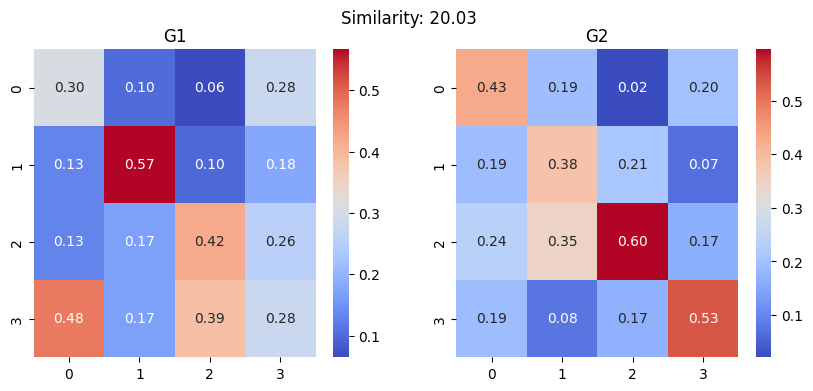

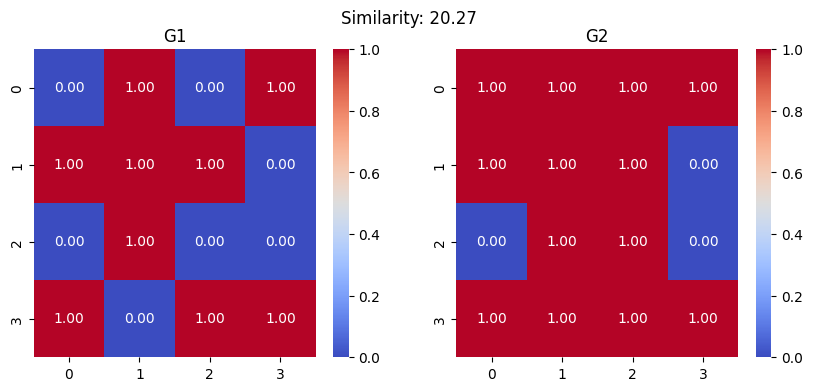

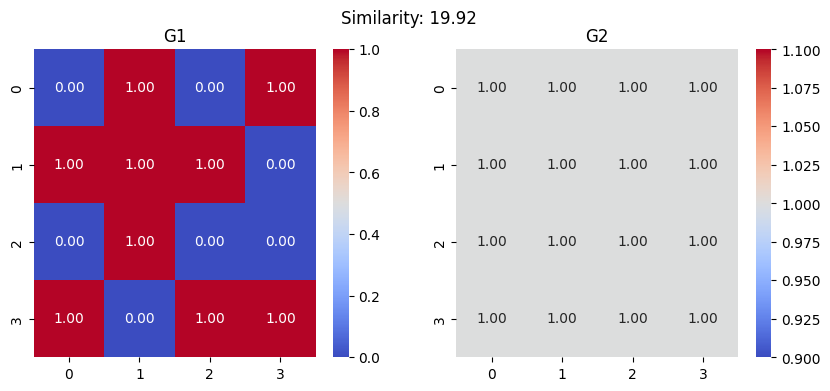

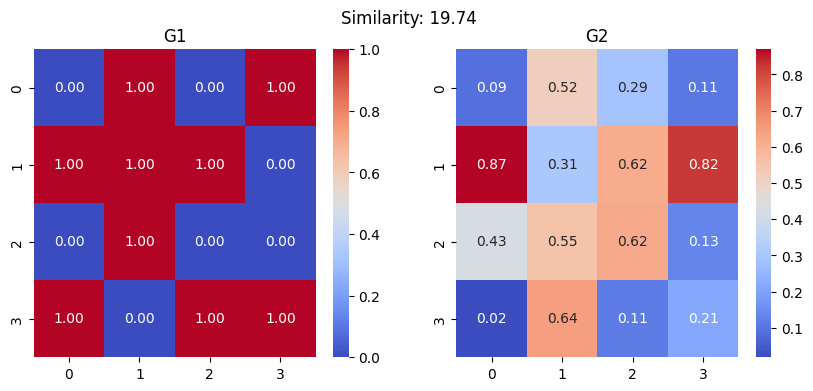

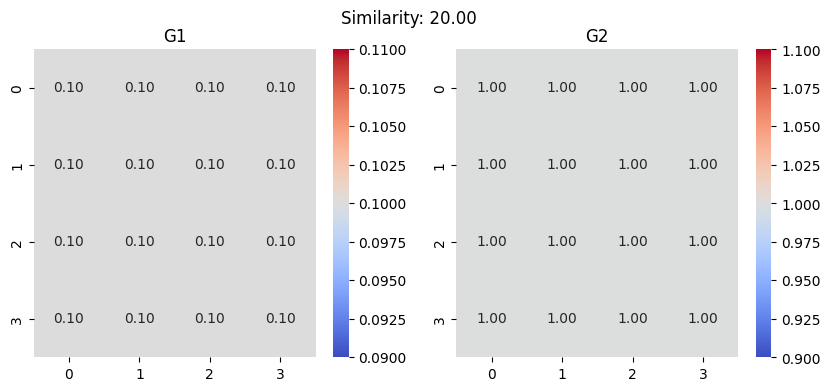

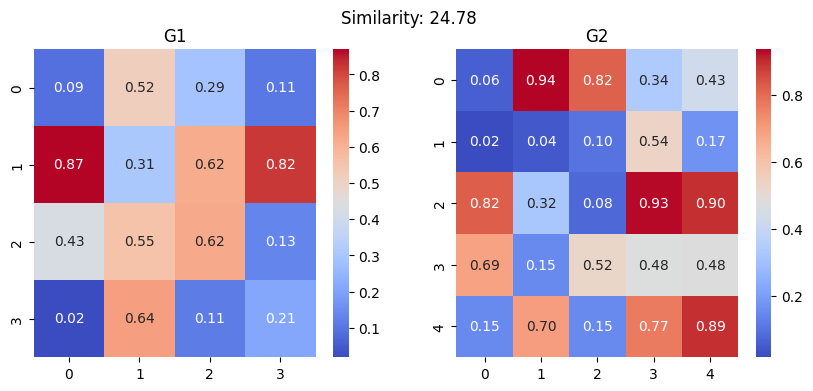

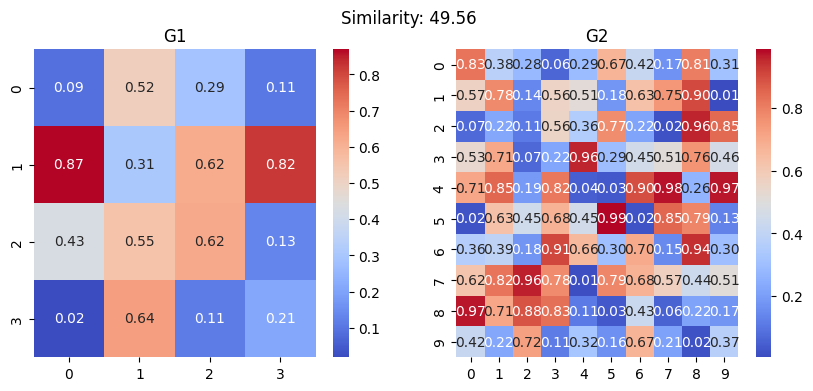

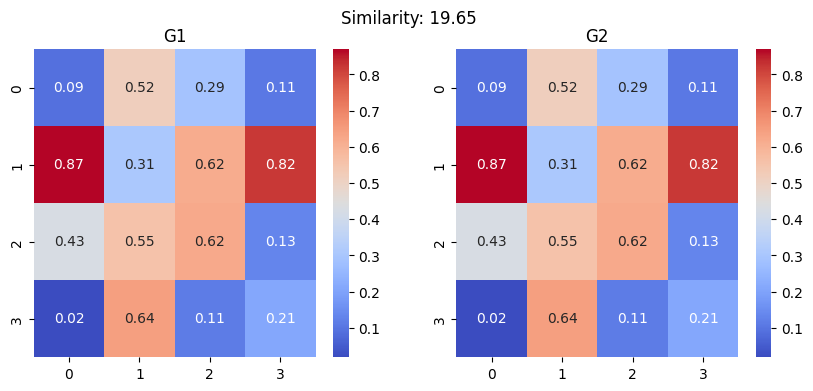

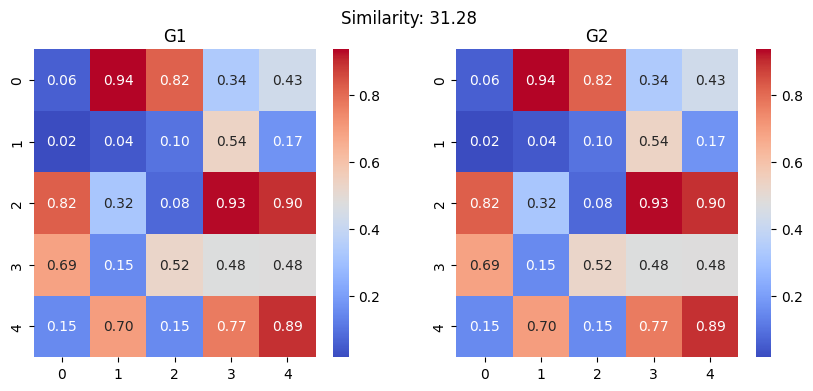

In [6]:
random_4 = np.array([
    [0, 1, 0, 1],
    [1, 1, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 1, 1]
])

almost_full_4  = np.array([
    [1, 1, 1, 1],
    [1, 1, 1, 0],
    [0, 1, 1, 0],
    [1, 1, 1, 1]
])


full_4  = np.array([
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1]
])


small_4  = np.array([
    [0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1],
    [0.1, 0.1, 0.1, 0.1]
])


uniform_4 =  np.random.uniform(0, 1, size=(4,4))

uniform_5 = np.random.uniform(0, 1, size=(5, 5), )

uniform_10 = np.random.uniform(0, 1, size=(10, 10), )


def heatmap_similarity(G1, G2, decay: float):
    similarity = weighted_random_walk_kernel(G1, G2, decay=decay, normalize=False)
    title = f"Similarity: {similarity:.2f}"
    heatmap_pair(G1, G2, main_title=title)

decay = 0.2
heatmap_similarity(td_matrix, asd_matrix, decay)
heatmap_similarity(random_4, almost_full_4, decay)
heatmap_similarity(random_4, full_4, decay)
heatmap_similarity(random_4, uniform_4, decay)
heatmap_similarity(small_4, full_4, decay)
heatmap_similarity(uniform_4, uniform_5, decay)
heatmap_similarity(uniform_4, uniform_10, decay)
heatmap_similarity(uniform_4, uniform_4, decay)
heatmap_similarity(uniform_5, uniform_5, decay)


# Shortest path kernel

- Determines the shortest path between each pair of node for both graphs, represents the graphs as an array of (v, u, l) tuples
- Calculates the similarity between the graph by comparing the shared shortest path using some kernel (RBF, delta, etc)

In [7]:
class ShortestPathKernel:

    @staticmethod
    def transition_to_cost_matrix(G_transition: np.ndarray) -> np.ndarray:
        G_cost = np.where(G_transition > 0, -np.log(G_transition), np.inf)
        np.fill_diagonal(G_cost, 0)  
        return G_cost


    @staticmethod
    def transition_matrix_to_graph(G_transition: np.ndarray) -> nx.Graph:
        G_cost = ShortestPathKernel.transition_to_cost_matrix(G_transition)
        G = nx.DiGraph()

        nodes = range(len(G_cost))
        for i in nodes:
            for j in nodes:
                cost = G_cost[i][j]
                if not np.isinf(cost):
                    G.add_edge(i, j, weight=cost)
        return G


    @staticmethod
    def get_feature_vector(G_transition: np.ndarray) -> dict:
        G = ShortestPathKernel.transition_matrix_to_graph(G_transition)
        shortest_paths = {}
        for i in G:
            for j in G:
                length = nx.dijkstra_path_length(G, source=i, target=j, weight='weight')
                shortest_paths[(i, j)] = length
        return shortest_paths
    

    @staticmethod
    def get_kernel_value(G_transition1: np.ndarray, G_transition2: np.ndarray, kernel, normalize: bool=False) -> float:
        shortest_paths1 = ShortestPathKernel.get_feature_vector(G_transition1)
        shortest_paths2 = ShortestPathKernel.get_feature_vector(G_transition2)
        K = 0.0
        shared_paths = shortest_paths1.keys() & shortest_paths2.keys()
        for path in shared_paths:
           K += kernel(shortest_paths1[path], shortest_paths2[path])
        if normalize:
            return K / len(shared_paths)
        return K

    
    @staticmethod
    def inverse_abs_diff_kernel(x: float, y:float) -> float:
        return 1 / (1 + np.abs(x - y))

    

''

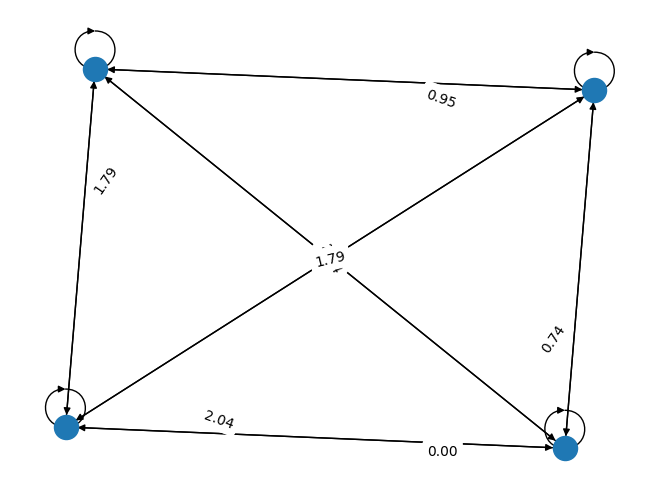

In [8]:
G = ShortestPathKernel.transition_matrix_to_graph(td_matrix)

edge_labels = {edge: f"{weight:.2f}" for edge, weight in nx.get_edge_attributes(G, 'weight').items()}
nx.draw(G=G, pos=nx.forceatlas2_layout(G))
nx.draw_networkx_edge_labels(G=G, edge_labels=edge_labels, pos=nx.forceatlas2_layout(G))
""

## Examples for shortest path kernel

/tmp/ipykernel_33000/1330475276.py:5: RuntimeWarning: divide by zero encountered in log
  G_cost = np.where(G_transition > 0, -np.log(G_transition), np.inf)
/tmp/ipykernel_33000/1330475276.py:5: RuntimeWarning: divide by zero encountered in log
  G_cost = np.where(G_transition > 0, -np.log(G_transition), np.inf)
/tmp/ipykernel_33000/1330475276.py:5: RuntimeWarning: divide by zero encountered in log
  G_cost = np.where(G_transition > 0, -np.log(G_transition), np.inf)


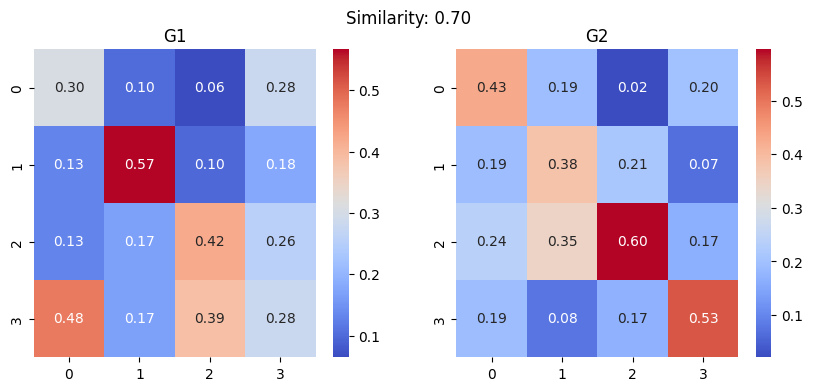

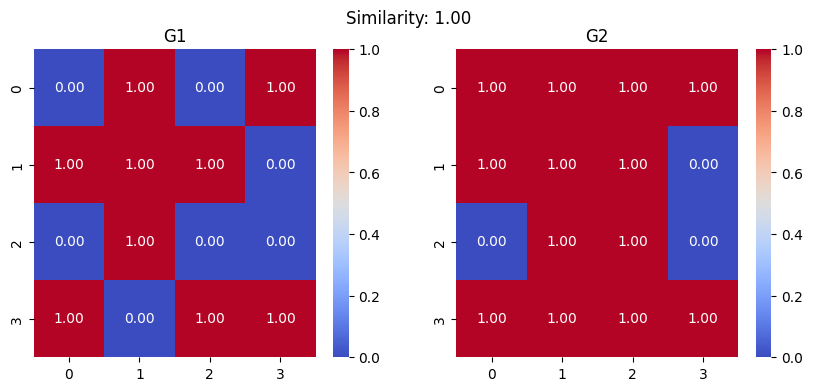

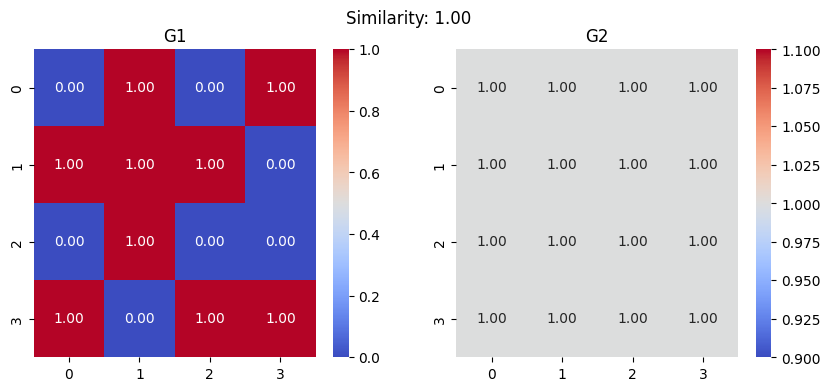

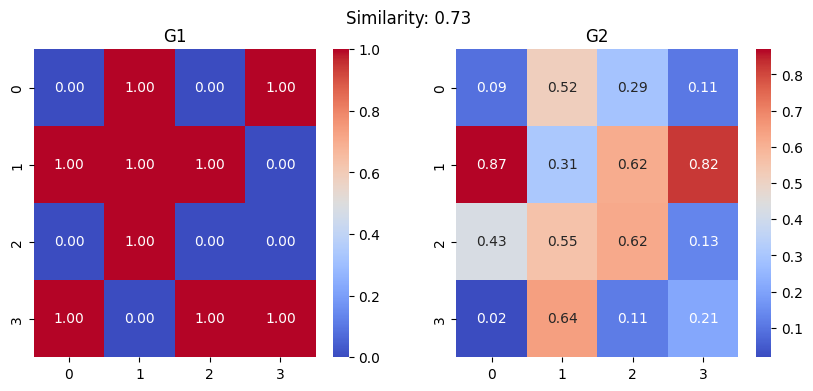

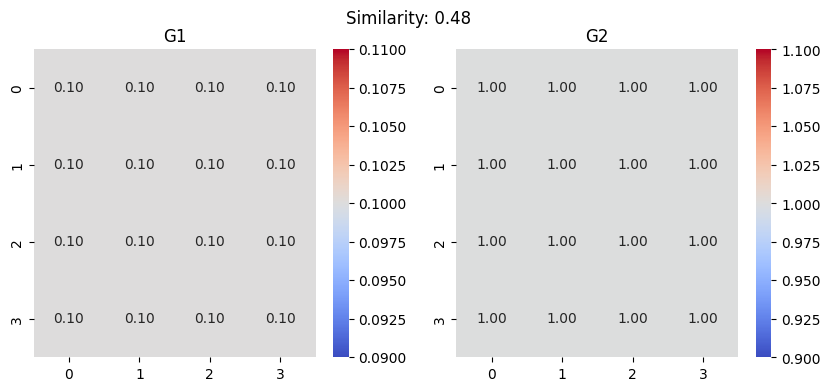

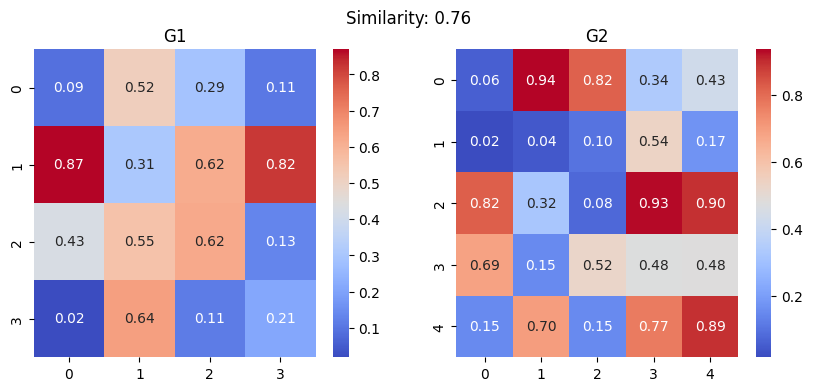

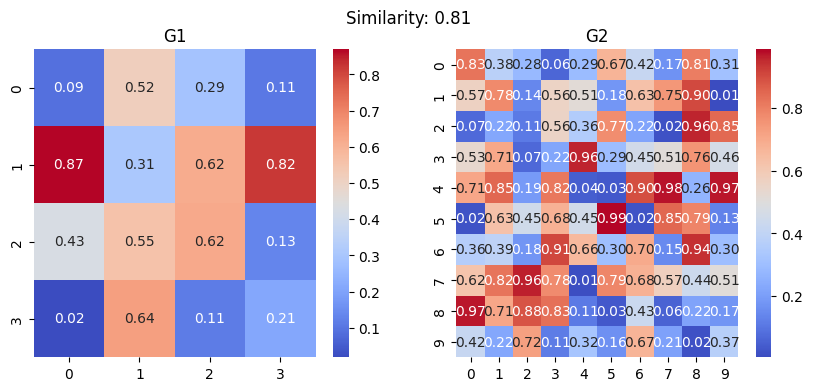

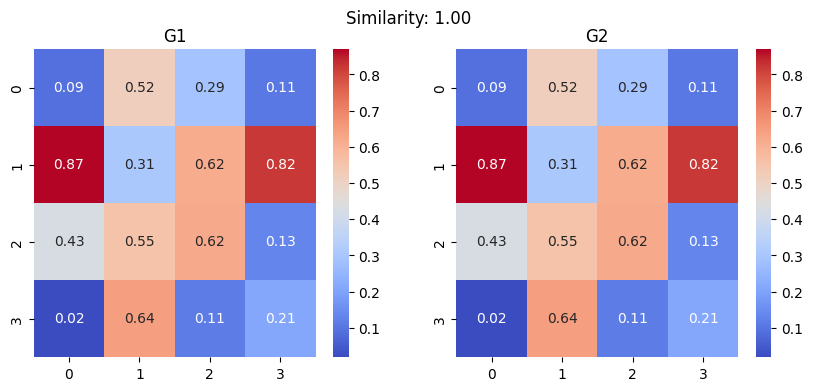

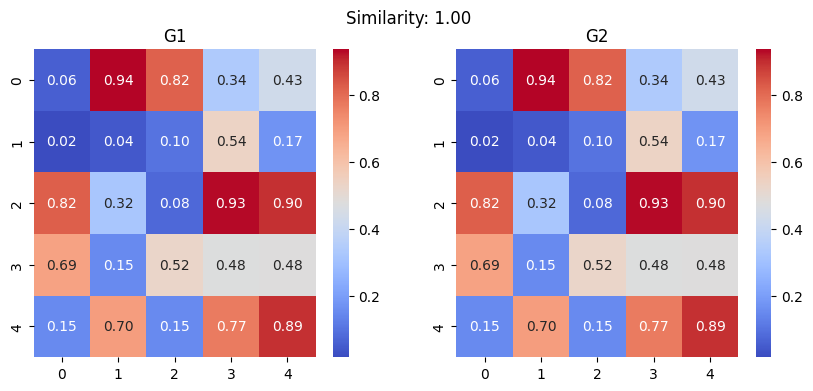

In [9]:
def kernel_similarity(G1, G2, decay: float):
    similarity = ShortestPathKernel.get_kernel_value(G1, G2, kernel=ShortestPathKernel.inverse_abs_diff_kernel, normalize=True)
    title = f"Similarity: {similarity:.2f}"
    heatmap_pair(G1, G2, main_title=title)

decay = 0.2
kernel_similarity(td_matrix, asd_matrix, decay)
kernel_similarity(random_4, almost_full_4, decay)
kernel_similarity(random_4, full_4, decay)
kernel_similarity(random_4, uniform_4, decay)
kernel_similarity(small_4, full_4, decay)
kernel_similarity(uniform_4, uniform_5, decay)
kernel_similarity(uniform_4, uniform_10, decay)
kernel_similarity(uniform_4, uniform_4, decay)
kernel_similarity(uniform_5, uniform_5, decay)


total time for 1: 1848
total time for 2: 3331
total time for 3: 3006
total time for 4: 3272
total time for 5: 3787
total time for 6: 2707
total time for 7: 4796
total time for 8: 3291
total time for 9: 4299
total time for 10: 8
total time for 11: 2048
total time for 12: 641
total time for 13: 3708


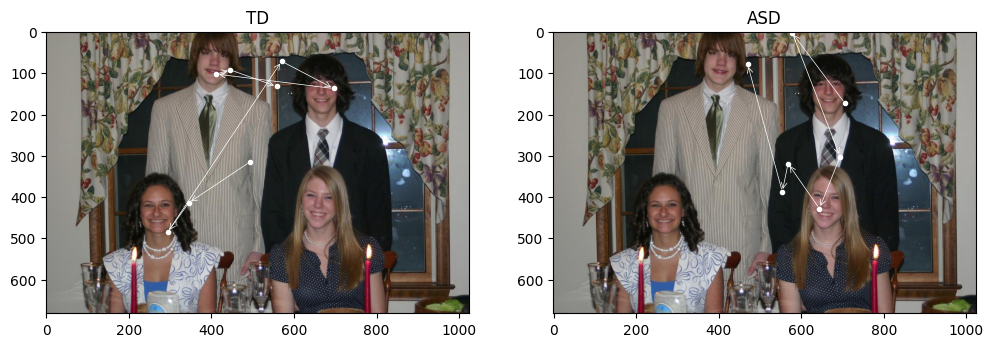

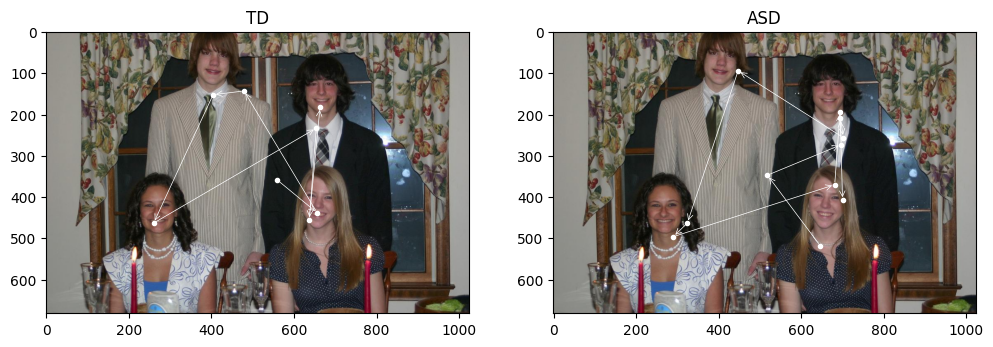

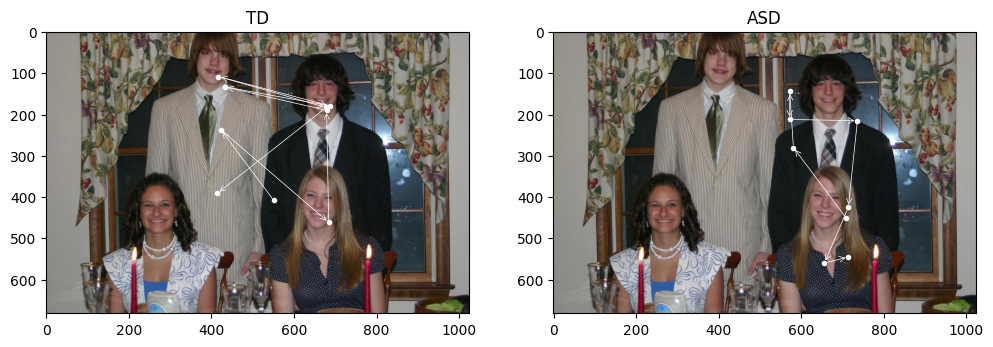

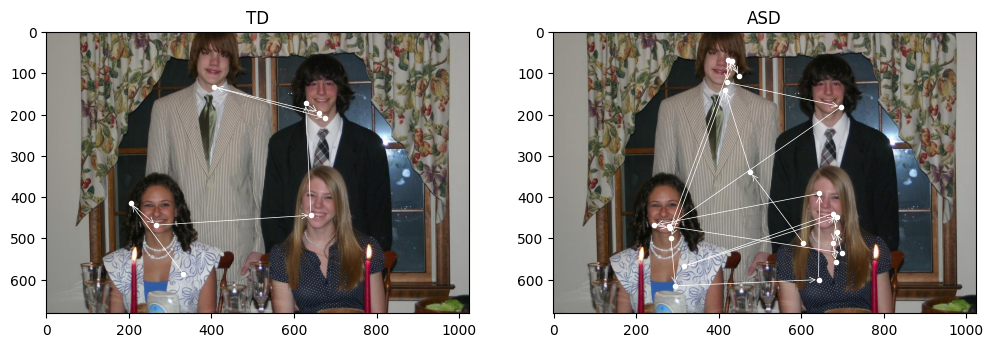

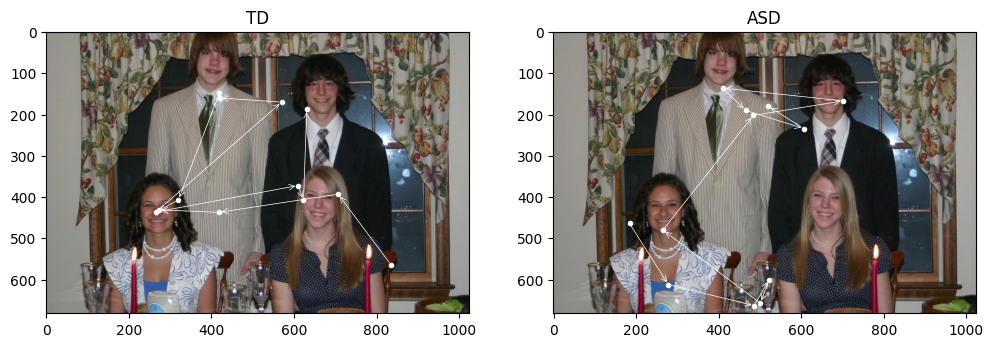

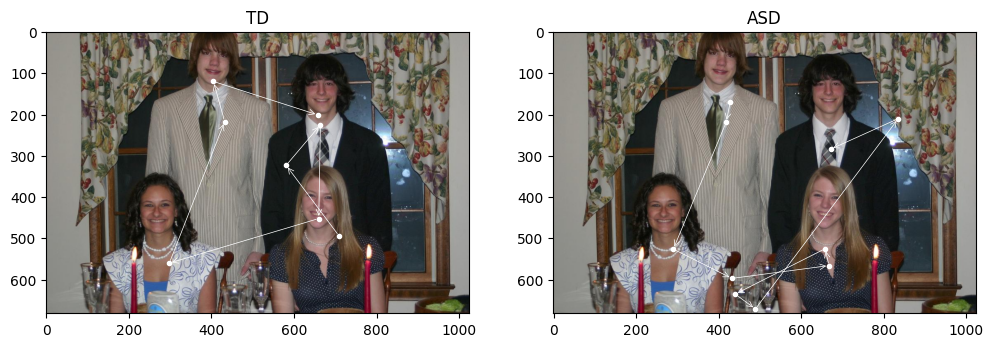

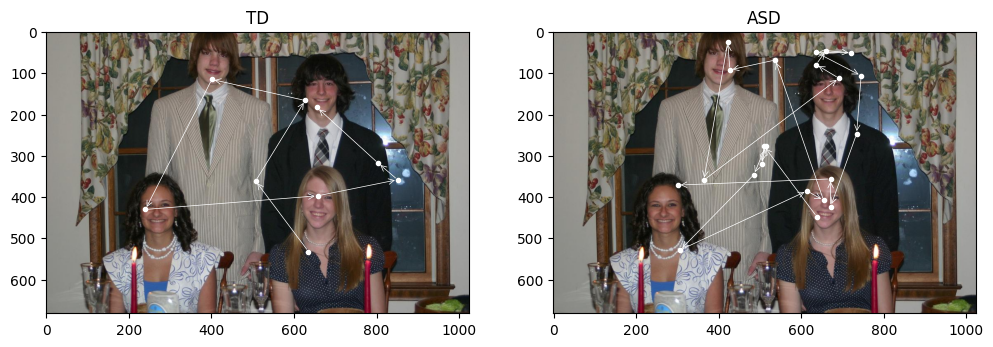

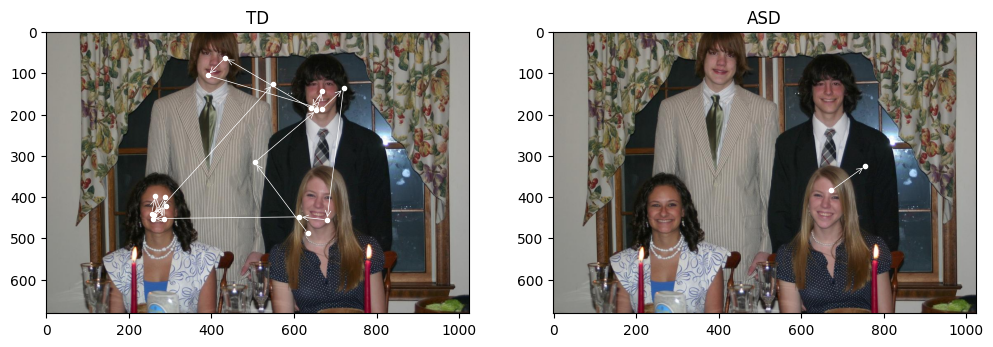

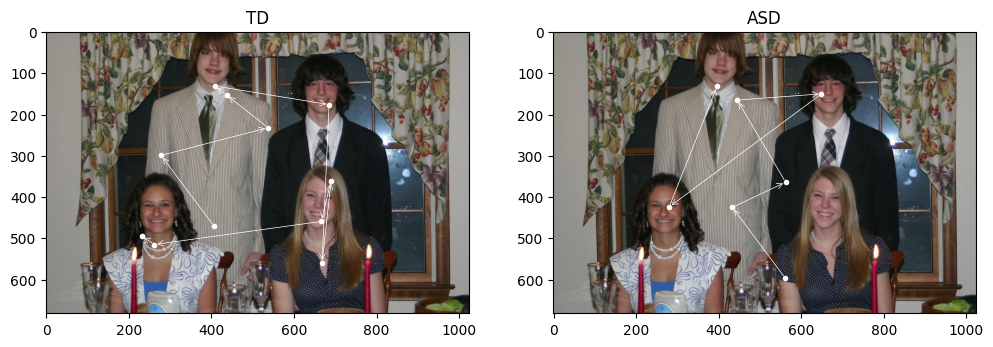

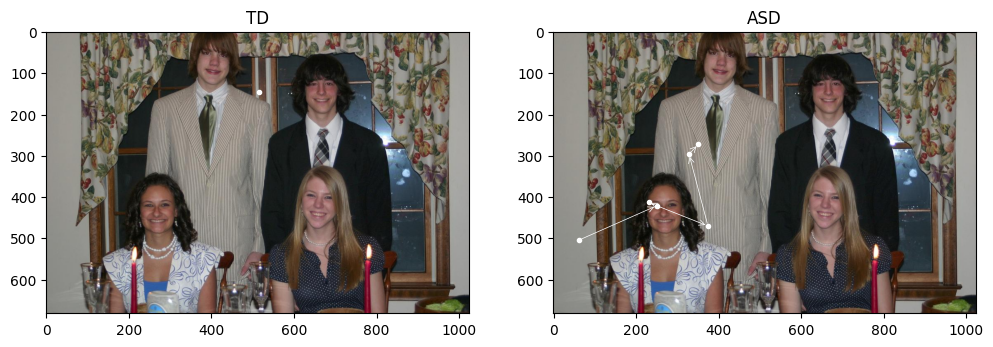

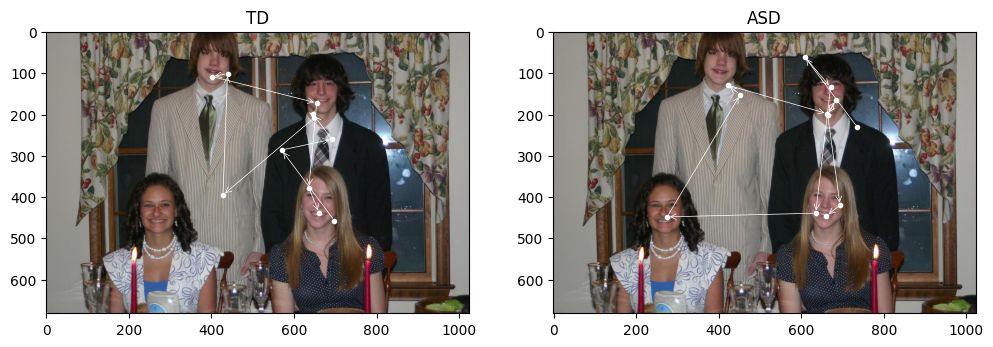

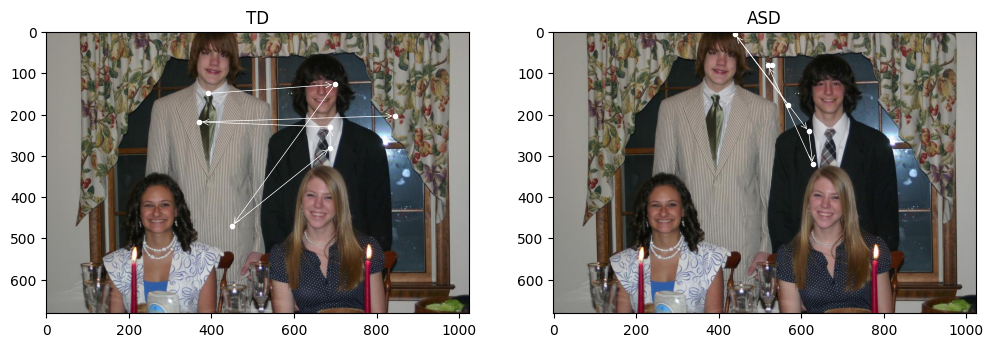

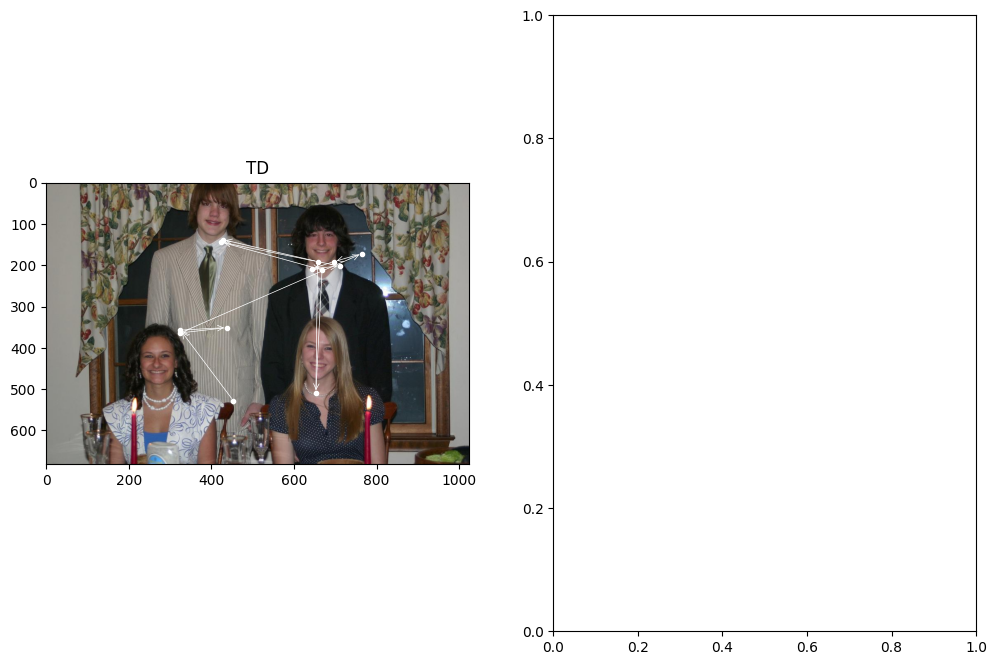

In [10]:
# used for checking how the individual measurements ar eactually structured
import pandas as pd

dataset_index = 56
img_path = f"../TrainingDataset/TrainingData/Images/{dataset_index}.png"
td_data_path = f"../TrainingDataset/TrainingData/TD/TD_scanpath_{dataset_index}.txt"
asd_data_path = f"../TrainingDataset/TrainingData/ASD/ASD_scanpath_{dataset_index}.txt"
td_data = pd.read_csv(td_data_path, usecols=[0, 1, 2, 3])
asd_data = pd.read_csv(asd_data_path, usecols=[0, 1, 2, 3])
td_data.columns = ["idx", "x", "y", "t"]
asd_data.columns = ["idx", "x", "y", "t"]

td_data["subject"] = (td_data['idx'] == 0).cumsum()
groups = [g for _, g in td_data.groupby('subject')]
td_datas = [group.reset_index(drop=True) for _, group in td_data.groupby('subject')]

asd_data["subject"] = (asd_data['idx'] == 0).cumsum()
groups = [g for _, g in asd_data.groupby('subject')]
asd_datas = [group.reset_index(drop=True) for _, group in asd_data.groupby('subject')]

for d in td_datas:
    get_closest_aoi(AOIS, d)

for d in asd_datas:
    get_closest_aoi(AOIS, d)

for i, d in enumerate(td_datas):
    try:
        print(f"total time for {i+1}: {sum(d['t'])}")
        fig, ax = plt.subplots(1, 2, figsize=(12, 8))
        trace_plot(ax[0], td_datas[i], AOIS),
        ax[0].imshow(image)
        ax[0].set(title="TD")

        trace_plot(ax[1], asd_datas[i], AOIS)
        ax[1].imshow(image)
        ax[1].set(title="ASD")
    except: pass

## Local metrics

### Betweenness centrality

### Closeness centrality

### Degree centrality

### Reach